# Tutorial: line extraction or seam carving

### All imports

In [1]:
import os

import point_group as gpoints
from proximity_segmentation import calculate_energy, ProximitySegmentation

import numpy as np
import scipy

import skimage.io as skio
import skimage.draw as skdr
import skimage.feature as skf
import skimage.filters as skfi
import skimage.transform as sktr
from skimage import img_as_uint, img_as_int
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

### Constants

In [2]:
src_folder = "input"

1) Retrieves an image, rotate the image and show it.

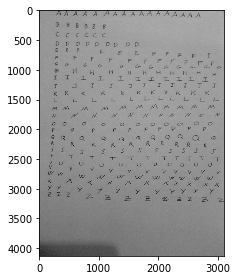

In [3]:
gray_image = skio.imread(os.path.join("input", "characters_sheet.jpg"), as_grey=True)
gray_image = sktr.rotate(gray_image, -90., resize=True)
skio.imshow(gray_image)
skio.show()
#plt.show()

2) Let's see into more details the image

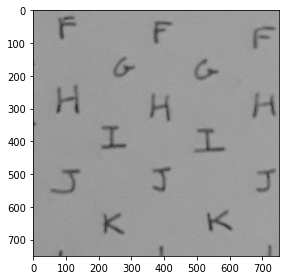

In [4]:
skio.imshow(gray_image[750:1500, 500:1250])
skio.show()

We can see hand-written characters: F, G, H, I J, K.

3) We just want to keep the letters and nothing else. Letters are characterized by a high contrast between the sheet and the ink. The Canny filter is one of the most used mask of convolution to find edges in images.
* A resizing is necessary to reduce the amount of computations.
* The Canny filter is applied in order to keep only strong edges.

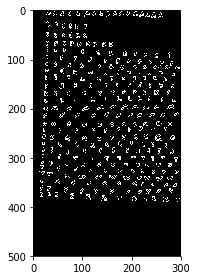

In [5]:
tt = 500
uu = 300
resized_image = sktr.resize(gray_image, (tt, uu))
image_canny = np.uint8(skf.canny(resized_image))*255
skio.imshow(image_canny)
skio.show()

----
The [**Canny filter**](https://en.wikipedia.org/wiki/Canny_edge_detector) is an elaborate filter. What is a filter in image processing domain? It is mask, i.e. a small matrix (around 3x3 or 5x5) which is *convolved* with an image. [Convolution](https://en.wikipedia.org/wiki/Convolution) is a mathematical operation used especially in signal processing.

-----

4) Now, lines... What kinds of features define lines? Blank lines are horizontal regions where there are no letters and on which letters are virtually put. We can make a filter which gives a weight to all points in an image. The more distant points of letters are, the lighter its weight is. I call these weigth "energy". Lines are trajectory of least-energy.

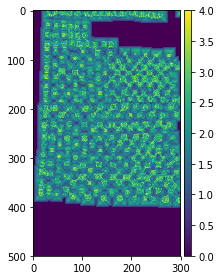

In [6]:
def calculate_energy(image):
    # size = 11
    energy = np.zeros(image.shape)
    size_max = 25
    width = 3
    for size in range(3, size_max, 4):
        kernel = np.ones((size, size))
        #kernel[:, int(size/2)-width:int(size/2)+width] = 1
        energy += (size_max-size)*scipy.ndimage.filters.convolve(image, kernel)
    #energy = np.max(energy)*(energy == np.zeros(image.shape)) + energy
    return energy/np.max(energy)*4

energy = calculate_energy(image_canny)
skio.imshow(energy)
skio.show()

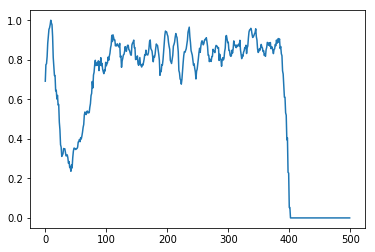

In [7]:
a = np.sum(energy, axis=1)/np.max(np.sum(energy, axis=1))
plt.plot(a)

The lines with low energy are likely to be lines enough far away from letters, except for lines which were not modified (i.e. for lines too far away from letters).

There are 145 n_lines.


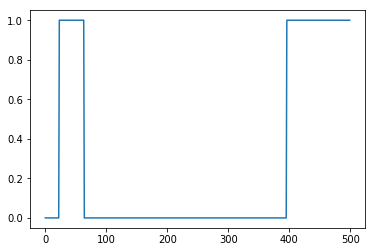

In [8]:
threshold = 0.5
under_threshold = a < np.ones(a.shape)*threshold
n_lines = np.sum(under_threshold)
plt.plot(under_threshold)
print(f"There are {n_lines} n_lines.")

Thus local minima correspond here to good lines seperating letters, even if it may be not enough. 

In [9]:
n_minima = np.sum(np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True])
print("Number of local minima: "+str(n_minima)+".")

Number of local minima: 90.


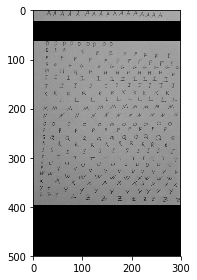

In [10]:
line_on_resized_image = resized_image.copy()
i = 0
for under in under_threshold:
    if under:
        rr, cc = skdr.draw.line(i, 0, i, line_on_resized_image.shape[1]-1)
        line_on_resized_image[rr, cc] = 0
    i += 1
skio.imshow(line_on_resized_image)
skio.show()

You can see above the results of our segmentation: sometimes good, sometimes bad. The line between A and B is good. Between B and C, and C and D, no line was found. F and H are wrapped by lines!

### Run-length Smearing

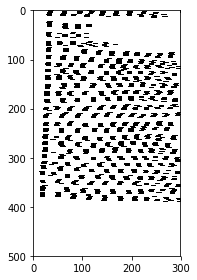

In [11]:
def fill_lines(image, threshold, gap_tolerance):
    image = image < np.ones(image.shape)*threshold
    new_image = np.zeros(image.shape)
    lines = []
    for line in range(image.shape[0]):
        color = image[line, 0]
        index = 0
        lines.append([[color, 1],])
        new_image[line, 0] = color
        for column in range(1, image.shape[1]):
            if image[line, column] == color:
                lines[line][index][1] += 1
                new_image[line, column] = color
            else:
                if lines[line][index][1] > gap_tolerance:
                    color = image[line, column]
                    #print(line, index)
                    lines[line].append([color, 1])
                    index += 1
                    new_image[line, column] = color
                else:
                    lines[line][index][1] += 1
                    new_image[line, column] = color
                    
                
    return new_image, lines
im_lines_filled, lines = fill_lines(image_canny, 0.5, 10)
skio.imshow(im_lines_filled)
skio.show()

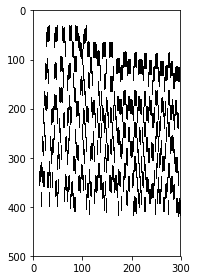

In [12]:
def fill_colums(image, threshold, gap_tolerance):
    image = image < np.ones(image.shape)*threshold
    new_image = np.zeros(image.shape)
    columns = []
    for column in range(image.shape[1]):
        color = image[0, column]
        index = 0
        columns.append([[color, 1],])
        new_image[0, column] = color
        for line in range(1, image.shape[0]):
            if image[line, column] == color:
                columns[column][index][1] += 1
                new_image[line, column] = color
            else:
                if columns[column][index][1] > gap_tolerance:
                    color = image[line, column]
                    #print(line, index)
                    columns[column].append([color, 1])
                    index += 1
                    new_image[line, column] = color
                else:
                    columns[column][index][1] += 1
                    new_image[line, column] = color
                    
                
    return new_image, columns
im_columns_filled, columns = fill_colums(image_canny, 0.5, 30)
skio.imshow(im_columns_filled)
skio.show()

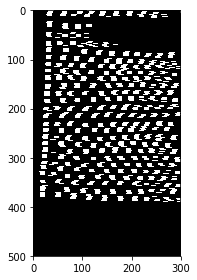

In [13]:
skio.imshow(im_columns_filled % im_lines_filled)
skio.show()

### X-Y Cut

Here is an other way to compute lines. Instead of energy, we compute a sort of histograms of sum of edges on lines and on columns.

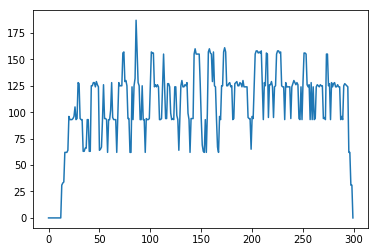

In [14]:
white_columns = [sum([content[1] for content in column if not content[0]])  for column in columns]
histogram_columns = plt.plot(white_columns)

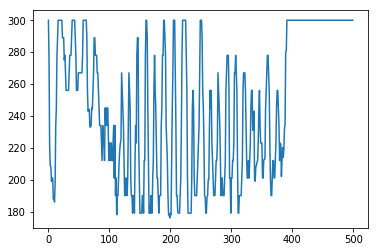

In [15]:
black_lines = np.array([sum([content[1] for content in line if content[0]])  for line in lines])
histogram_lines = plt.plot(black_lines)

In [16]:
somme = np.sum(np.r_[True, black_lines[1:] < black_lines[:-1]] *
               np.r_[black_lines[:-1] < black_lines[1:], True])
print("Number of local minima: "+str(somme)+".")

Number of local minima: 31.


### Docstrum

### Whitespace Analysis

### Voronoi

Proposed idea in [1]

Seam traversal

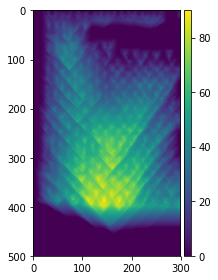

In [17]:
k = 1
mdp = np.zeros(energy.shape)
mdp[0, :] = energy[0, :].copy()
mdp[:, 0] = energy[:, 0].copy()
for line in range(1, mdp.shape[0]):
    for column in range(1, mdp.shape[1]):
        if column == mdp.shape[1] - 1:
            if energy[line, column] + min([mdp[line-1, column-1], 
                                           mdp[line-1, column]]) >= k:
                mdp[line, column] = energy[line, column] + min([mdp[line-1, column-1],
                                                           mdp[line-1, column]]) - k
        else:
            if energy[line, column] + min([mdp[line-1, column-1], 
                                           mdp[line-1, column], 
                                           mdp[line-1, column+1]]) >= k:
                mdp[line, column] = energy[line, column] + min([mdp[line-1, column-1],
                                                           mdp[line-1, column],
                                                           mdp[line-1, column+1]]) - k
np.argmin(mdp[:, -1])
skio.imshow(mdp)
skio.show()

## Characters extraction

1) Retrieval of gray-scaled image

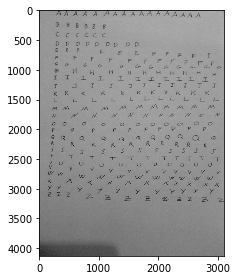

In [18]:
src_folder = "input"
src_picture = "characters_sheet.jpg"
dst_folder = "letters"

gray_image = skio.imread(os.path.join(src_folder, src_picture), as_grey=True)
gray_image = sktr.rotate(gray_image, -90., resize=True)
skio.imshow(gray_image)
skio.show()

2) Resizing

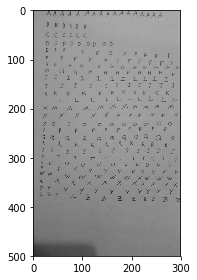

In [19]:
tt = 500
uu = 300
resized_image = sktr.resize(gray_image, (tt, uu))
skio.imshow(resized_image)
skio.show()

3) Applying Canny filter

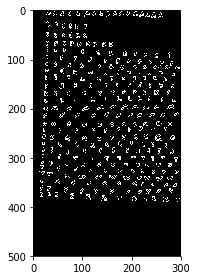

In [ ]:
image_canny = np.uint8(skf.canny(resized_image))*255
skio.imshow(image_canny)
skio.show()

4) Character segmentation

In [ ]:
pc = gpoints.PointGroup()
for i in range(uu):
    for j in range(tt):
        if image_canny[j, i] == 255:
            pc.append_point(gpoints.Point(i, j))
print("Points added")
spp = ProximitySegmentation(pc, 3)
spp.segment()


Points added


In [ ]:
print("Number of characters detected:", len(spp.tags))

5) Character extraction

In [ ]:
hh = 0
if not os.path.exists(dst_folder):
    os.mkdir(dst_folder)
l_mini_images = []
for gp in spp.tags:
    if gp.calculate_min_y() - 5 >= 0 and gp.calculate_max_y()+5 < tt and \
            gp.calculate_min_x()-5 >= 0 and gp.calculate_max_x()+5 < uu:
        mini_im = resized_image[gp.calculate_min_y() - 5:gp.calculate_max_y() + 5,
            gp.calculate_min_x() - 5:gp.calculate_max_x() + 5]
        l_mini_images.append(mini_im)
        hh += 1
print("S")
skio.imshow(l_mini_images[30])
skio.show()
print("F")
skio.imshow(l_mini_images[50])
skio.show()
print("I")
skio.imshow(l_mini_images[200])
skio.show()

We can see an S, an F and an I! Wonderful, isn't it?

## Sources

* [1] [TEXT LINE EXTRACTION USING SEAM CARVING - master thesis](https://etd.ohiolink.edu/!etd.send_file?accession=akron1428077337&disposition=inline) by Christopher Stoll
* [2] [TEXT LINE EXTRACTION USING SEAM CARVING - paper](http://worldcomp-proceedings.com/proc/p2015/IPC3194.pdf)
* [3] [Seam Carving for Text Line Extraction on Color and Grayscale Historical Manuscripts](https://infoscience.epfl.ch/record/198756/files/ICFHR_2014.pdf)
* [4] [Text line and word segmentation of handwritten documents](http://users.iit.demokritos.gr/~bgat/Louloud_1_2009.pdf)
* [5] [Improving Handwritten Chinese Text Recognition by Unsupervised Language Model Adaptation](http://www.nlpr.ia.ac.cn/2012papers/gjhy/gh34.pdf)



## Author:
Clément Besnier, Twitter [@clemsciences](https://twitter.com/clemsciences) and  [my personal website](https://clementbesnier.pythonanywhere.com)
    